In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0005
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 40016
SL_VALIDATION_SIZE = 9634
SL_TEST_SIZE = 13037
BKG_TEST_SIZE = 277390
EPOCHS = 30
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1
MAX_EPOCHS_WITH_SAME_DATA_SET = 20
TEST_STEPS = (SL_TEST_SIZE + BKG_TEST_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_2_model.h5"

MR_CKPT_PATH = "./binary_classifier/net_2_most_recent_checkpoint.hdf5"
CB_CKPT_PATH = "./binary_classifier/net_2_current_best_checkpoint.hdf5"

In [3]:
# Load model

model = keras.models.load_model(MODEL_PATH)

In [4]:
# Test

test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate model on test data through flow_from_directory
loss_and_metrics = model.evaluate_generator(test_datagen.flow_from_directory(
    directory=TEST_PATH, 
    target_size=(IM_HEIGHT, IM_WIDTH),
    classes=['0_sea_lions', '1_background'],
    batch_size=BATCH_SIZE
), steps=TEST_STEPS, workers=8, max_queue_size=50)

print("%s: %.2f%%" % (model.metrics_names[1], loss_and_metrics[1]*100))

Found 290427 images belonging to 2 classes.
acc: 94.85%


In [5]:
def prediction_generator_ffd():
    test_gen = ImageDataGenerator(rescale=1./255)
    for x, y in test_gen.flow_from_directory(directory=TEST_PATH, target_size=(IM_HEIGHT, IM_WIDTH), classes=['0_sea_lions', '1_background'], shuffle=False, batch_size=BATCH_SIZE):
        yield x

Found 290427 images belonging to 2 classes.
[0.9209988  0.951856   0.66828364 ... 0.10079549 0.17303064 0.15439916]
[0.07900119 0.04814393 0.33171636 ... 0.89920455 0.8269693  0.84560084]
[1 1 1 ... 0 0 0]


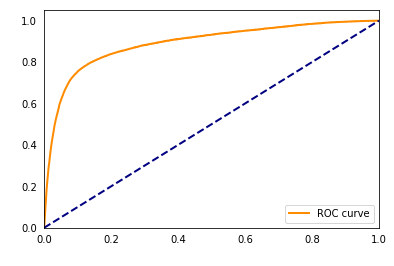

In [6]:
# Plot ROC
Y_tmp = []
gen = prediction_generator_ffd()
Y_pred_bin = model.predict_generator(gen, steps=TEST_STEPS)
Y_pred = Y_pred_bin[:, 0]
print(Y_pred)
print(Y_pred_bin[:,1])
Y_roc_true_bin = np.array([[1, 0]]*SL_TEST_SIZE + [[0, 1]]*BKG_TEST_SIZE)
Y_roc_true = Y_roc_true_bin[:, 0]
print(Y_roc_true)
# print(np.shape(Y_roc_true))
# print(np.shape(Y_pred))
fpr, tpr, _ = metrics.roc_curve(Y_roc_true, Y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.tick_params(which='both', color='white')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Evaluate AUC of the ROC
metrics.roc_auc_score(Y_roc_true, Y_pred)

0.8898254029358128

In [8]:
#Compute precision and recall

tp = 0
fp = 0
tn = 0
fn = 0

for i in range(len(Y_pred)):
    if Y_pred[i] > 0.5:
        if Y_roc_true[i] == 1:
            tp += 1
        else:
            fp += 1
    else:
        if Y_roc_true[i] == 1:
            fn += 1
        else:
            tn += 1
            
sea_lion_prec = tp / (tp + fp)
sea_lion_reca = tp / (tp + fn)
background_prec = tn / (tn + fn)
background_reca = tn / (tn + fp)

print('sea lions: \nprecision %8.4f, recall %8.4f' % (sea_lion_prec, sea_lion_reca))
print('background: \nprecision %8.4f, recall %8.4f' % (background_prec, background_reca))

sea lions: 
precision   0.4324, recall   0.4729
background: 
precision   0.9751, recall   0.9708


Text(0.5,1,'2-class Precision-Recall curve: AP=0.37')

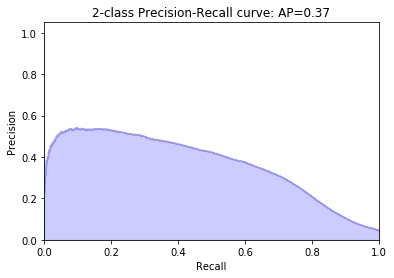

In [9]:
#Plot precision-recall curve 

average_precision = average_precision_score(Y_roc_true, Y_pred)
precision, recall, _ = precision_recall_curve(Y_roc_true, Y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [10]:
# Free memory

X_test = []
Y_test = []

In [11]:
# Save wrong predicted patches

lst = []
wrong_lst = []
tmp = os.listdir(TEST_PATH + '0_sea_lions')
for elem in tmp:
    lst.append(list((TEST_PATH + '0_sea_lions/' + elem, 'sea_lion')))
tmp = rand.sample(os.listdir(TEST_PATH + '1_background'), SL_TEST_SIZE)
for elem in tmp:
    lst.append(list((TEST_PATH + '1_background/' + elem, 'background')))
for elem in lst:
    img = cv2.imread(elem[0])
    X = np.reshape(img_to_array(img), (1, 96, 96, 3))
    X.astype('float32')
    X /= 255
    if elem[1] == 'sea_lion':
        expected_class = [1, 0]
    else:
        expected_class = [0, 1]
    prediction = model.predict(X, batch_size=1)
    if prediction[0][0] > prediction[0][1]:
        predicted_class = [1, 0]
        if predicted_class == expected_class:
            tp += 1
        else:
            fp += 1
    else:
        predicted_class = [0, 1]
        if predicted_class == expected_class:
            tn += 1
        else:
            fn += 1
    if not(expected_class == predicted_class):
        wrong_lst.append(list((elem[0], elem[1], prediction[0][0], prediction[0][1])))

wrong_prediction_df = pd.DataFrame(data=wrong_lst, columns=["image_path", "expected_class", "sl_probability", "bkg_probability"])
wrong_prediction_df.to_csv("./wrong_predictions.csv", index=False)

sea_lion_prec = tp / (tp + fp)
sea_lion_reca = tp / (tp + fn)
print('sea lions: \nprecision %8.4f, recall %8.4f' % (sea_lion_prec, sea_lion_reca))

sea lions: 
precision   0.6876, recall   0.7298


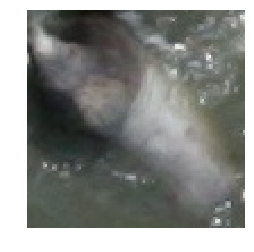

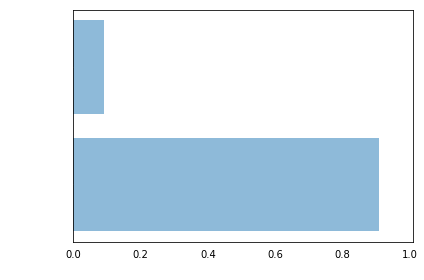

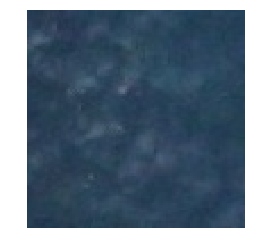

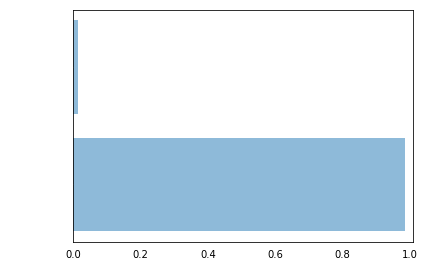

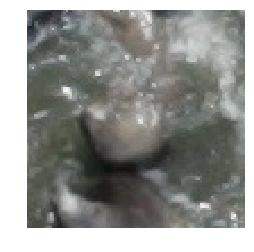

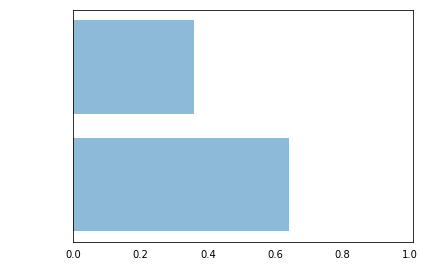

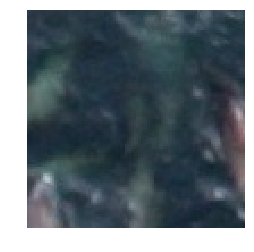

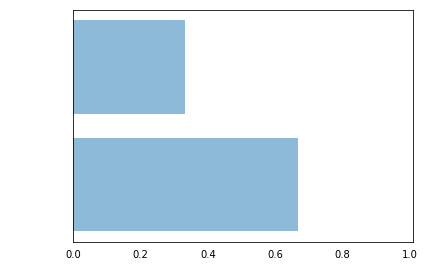

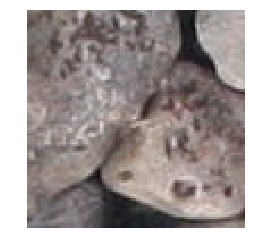

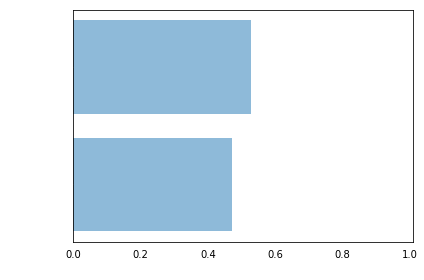

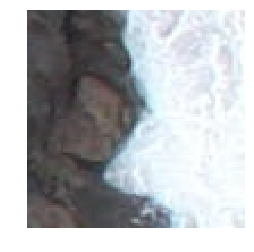

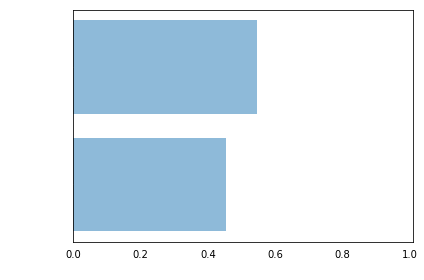

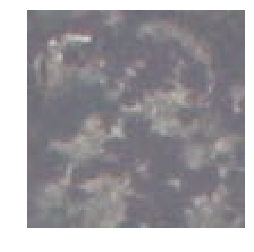

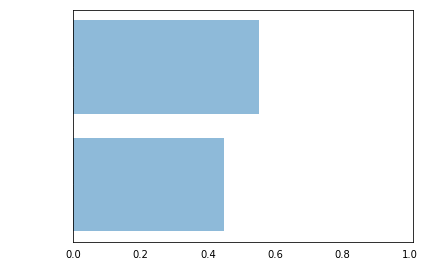

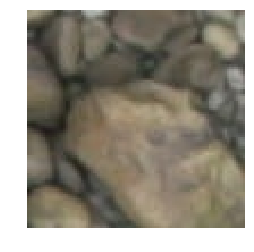

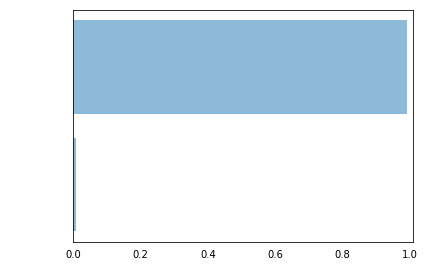

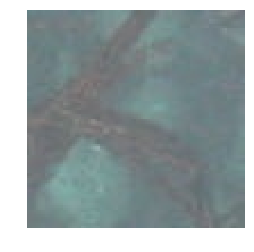

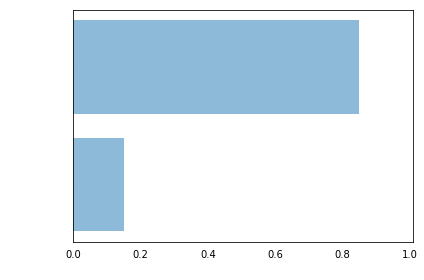

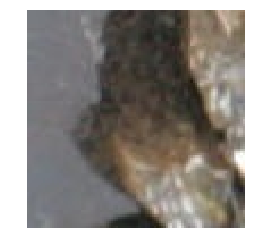

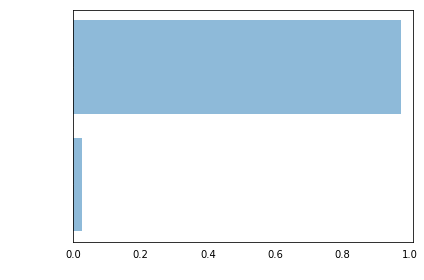

In [12]:
wrong_prediction_df = pd.read_csv("./wrong_predictions.csv")
for row in wrong_prediction_df.sample(10).iterrows():
   
    image = cv2.imread(row[1]['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preds = [row[1]['sl_probability'], row[1]['bkg_probability']]
    plt.imshow(image)
    plt.axis('off')
    
    plt.figure()
    order = list(reversed(range(len(preds))))
    labels = ['sea lion', 'background']
    plt.barh(order, preds, alpha=0.5)
    plt.yticks(order, labels, color='white')
    plt.xlabel('Probability', color='white')
    plt.xlim(0, 1.01)
    plt.tick_params(which='both', color='white')
    plt.tight_layout()
    plt.show()